In [2]:
import sys
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from IPython.display import display_html, Image

In [3]:
sfa_scores = (pd.read_csv("../int/sfa/interaction_scores.profile", delim_whitespace=True)
                .assign(IID=lambda x: pd.to_numeric(x.IID, errors="coerce"))
                .loc[:,['IID','SCORE']] 
                .dropna()
                .assign(IID=lambda x: x.IID.astype(int)))

meta_whi = pd.read_csv("../int/metaData_whi.csv")

scores_df = pd.merge(meta_whi, sfa_scores, left_on="subjID", right_on="IID")

scores_dm_df = scores_df.query('dm_trial == True and visitYear == 0 and lipid_med == False')
scores_nondm_df = scores_df.query('dm_trial == False and visitYear == 0 and lipid_med == False')

scores_dm_intervention_df = (scores_df
                             .query('dm_intervention == True')
                             .groupby(['subjID', 'SCORE', 'age', 'race', 'sex'])
                             .agg({'ldl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'hdl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'tg': lambda x: x.iloc[-1] - x.iloc[0],
                                   'sbp': lambda x: x.iloc[-1] - x.iloc[0]}))

scores_dm_control_df = (scores_df
                             .query('dm_intervention == False')
                             .groupby(['subjID', 'SCORE', 'age', 'race', 'sex'])
                             .agg({'ldl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'hdl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'tg': lambda x: x.iloc[-1] - x.iloc[0],
                                   'sbp': lambda x: x.iloc[-1] - x.iloc[0]}))

## GWIS --> weighted sum method for SFA response score generation

This method involves first performing a genome-wide interaction study for SNPs modifying the (modest) positive relationship between SFA and LDL in cross-sectional cohorts. Datasets used:

* FHS -- ~2.7k subjects not taking statins at Exam 5
* WHI -- ~10k subjects not taking statins at baseline and not in the dietary modification trial  

Fixed-effects meta-analysis was used to combine GWIS results, providing the input for a clumping/pruning procedure (Plink's clump method) to extract independent signals corresponding to ~250 SNPs. The Manhattan plot for the meta-analysis results is shown below:

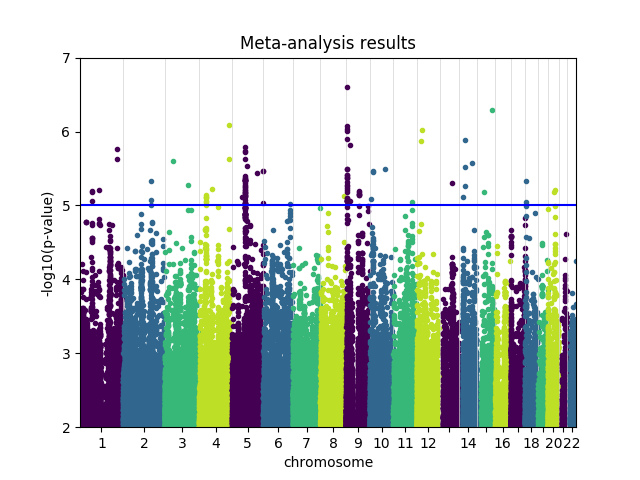

In [3]:
Image("../int/sfa/fhs_whi_manhattan.png")

Using these pruned meta-analysis coefficients as weights, polygenic "responder scores" were calculated in participants in the WHI dietary modification trial.

### Cross-sectional results in WHI DM subjects (baseline)

Text(0,0.5,u'Count')

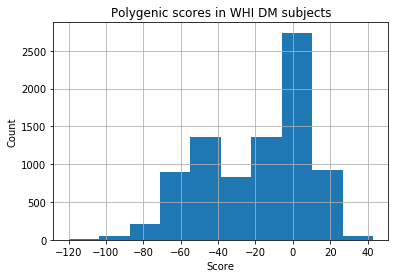

In [4]:
scores_dm_df.SCORE.hist()
plt.title("Polygenic scores in WHI DM subjects")
plt.xlabel("Score")
plt.ylabel("Count")

Regression of LDL on SFA and a score:SFA interaction term (adjusting for age and PUFA intake):

In [5]:
(smf.ols("ldl ~ sfa + SCORE:sfa + pufa + age", data=scores_dm_df)
 .fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,139.3090,5.915,23.554,0.000,127.714,150.904
sfa,177.8729,190.000,0.936,0.349,-194.603,550.348
SCORE:sfa,7.1022,1.325,5.358,0.000,4.504,9.701
pufa,-521.8877,222.309,-2.348,0.019,-957.701,-86.075
age,0.1969,0.075,2.620,0.009,0.050,0.344


/cluster/kappa/90-days-archive/rt/software/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,u'Slope of SFA -> LDL relationship')

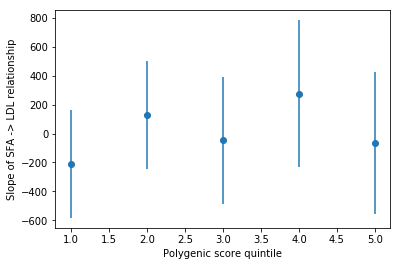

In [6]:
n_quantiles = 5

scores_dm_df['quant'] = pd.qcut(scores_dm_df.SCORE, n_quantiles)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ sfa + pufa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa)

param_estimates = [find_slope(scores_dm_df[scores_dm_df.quant == q]) 
                   for q in scores_dm_df.quant.cat.categories]

slopes, ses = zip(*param_estimates)

plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")

As a positive control, we confirm that the score has very strong predictive power in the non-DM portion of WHI (a.k.a. a significant portion of the training set).

In [7]:
(smf.ols("ldl ~ sfa + SCORE:sfa + pufa + age", data=scores_nondm_df)
 .fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,137.2572,3.629,37.827,0.000,130.144,144.370
sfa,227.9686,108.213,2.107,0.035,15.851,440.086
SCORE:sfa,15.0210,1.048,14.336,0.000,12.967,17.075
pufa,13.6523,161.026,0.085,0.932,-301.990,329.294
age,0.1804,0.051,3.507,0.000,0.080,0.281


/cluster/kappa/90-days-archive/rt/software/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,u'Slope of SFA -> LDL relationship')

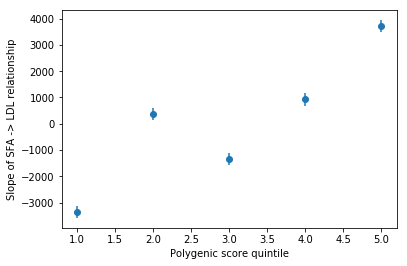

In [8]:
n_quantiles = 5

scores_nondm_df['quant'] = pd.qcut(scores_nondm_df.SCORE, n_quantiles)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ sfa + pufa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa)

param_estimates = [find_slope(scores_nondm_df[scores_nondm_df.quant == q]) 
                   for q in scores_nondm_df.quant.cat.categories]

slopes, ses = zip(*param_estimates)

plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")

### Longitudinal results in dietary modification intervention subjects

Now, examining the performance of the score in predicting LDL change over time in WHI DM subjects randomized to the dietary modification (which included recommendations to reduce SFA consumption).

In [9]:
scores_dm_intervention_df['SCORE'] = scores_dm_intervention_df.index.get_level_values('SCORE')
scores_dm_intervention_df['race'] = scores_dm_intervention_df.index.get_level_values('race')
scores_dm_intervention_df['age'] = scores_dm_intervention_df.index.get_level_values('age')

scores_dm_control_df['SCORE'] = scores_dm_control_df.index.get_level_values('SCORE')
scores_dm_control_df['race'] = scores_dm_control_df.index.get_level_values('race')
scores_dm_control_df['age'] = scores_dm_control_df.index.get_level_values('age')

(smf.ols("ldl ~ SCORE", data=scores_dm_intervention_df)
 .fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-17.9539,2.418,-7.426,0.000,-22.708,-13.200
SCORE,-0.2185,0.056,-3.928,0.000,-0.328,-0.109


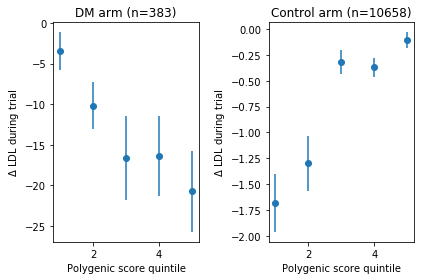

In [10]:
n_quantiles = 5

scores_dm_intervention_df['quant'] = pd.qcut(scores_dm_intervention_df.SCORE, n_quantiles)
scores_dm_control_df['quant'] = pd.qcut(scores_dm_control_df.SCORE, n_quantiles)

def find_ldl_change(sub_df):
    return (sub_df.ldl.mean(), sub_df.ldl.std()/np.sqrt(sub_df.ldl.count()))

change_estimates_intervention = [find_ldl_change(
    scores_dm_intervention_df[scores_dm_intervention_df.quant == q]) 
                    for q in scores_dm_intervention_df.quant.cat.categories]
change_estimates_control = [find_ldl_change(
    scores_dm_control_df[scores_dm_control_df.quant == q]) 
                    for q in scores_dm_control_df.quant.cat.categories]

deltas, ses = zip(*change_estimates_intervention)
plt.subplot(1, 2, 1)
plt.errorbar(x=range(1,n_quantiles+1), y=deltas, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("$\Delta$ LDL during trial")
plt.title("DM arm (n={})".format(scores_dm_intervention_df.ldl.count()))
plt.tight_layout()
deltas, ses = zip(*change_estimates_control)
plt.subplot(1, 2, 2)
plt.errorbar(x=range(1,n_quantiles+1), y=deltas, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("$\Delta$ LDL during trial")
plt.title("Control arm (n={})".format(scores_dm_control_df.ldl.count()))
plt.tight_layout()

### Replication in BPRHS

Population consists of ~1300 Puerto Rican subjects living in Boston.

In [11]:
# Bring in BPRHS
meta_bprhs = (pd.read_csv("../int/metaData_bprhs.csv")
              .loc[:, ['studyid', 'age', 'bmi', 'sfa', 'pufa', 'lipid_med',
                       'ldl', 'hdl', 'tg', 'sysbp']]
              .query('lipid_med == False'))

bprhs_id_link = pd.read_csv("../data/bprhs/admin/BPRHS_id_link.csv")

bprhs_scores = (pd.read_csv("../int/bprhs/sfa_scores.sscore", delim_whitespace=True)
                .loc[:, ['IID', 'SCORE1_AVG']])
bprhs_scores.columns = ['nelid_b', 'SCORE']
bprhs_scores['nelid_b'] = bprhs_scores['nelid_b'].astype(str)

scores_df_bprhs = (pd.merge(meta_bprhs, bprhs_id_link, on='studyid')
                   .merge(bprhs_scores, on='nelid_b'))

In [12]:
smf.ols('ldl ~ pufa + sfa + sfa:SCORE', data=scores_df_bprhs).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,113.6067,6.321,17.974,0.000,101.200,126.013
pufa,-440.9015,483.825,-0.911,0.362,-1390.557,508.754
sfa,539.0380,486.878,1.107,0.269,-416.608,1494.684
sfa:SCORE,6.5168,9.278,0.702,0.483,-11.695,24.729


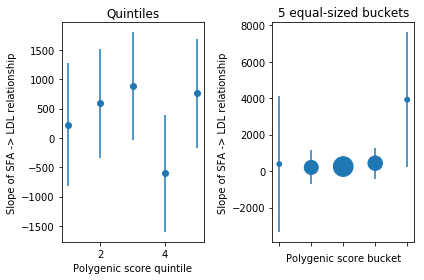

In [13]:
n_quantiles = 5
n_buckets = 5

scores_df_bprhs['quant'] = pd.qcut(scores_df_bprhs.SCORE, n_quantiles)
scores_df_bprhs['bucket'] = pd.cut(scores_df_bprhs.SCORE, n_buckets)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ pufa + sfa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa, reg_fit.nobs)

param_estimates = [find_slope(scores_df_bprhs[scores_df_bprhs.quant == q]) 
                   for q in scores_df_bprhs.quant.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 1)
plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("Quintiles")
plt.tight_layout()

param_estimates = [find_slope(scores_df_bprhs[scores_df_bprhs.bucket == q]) 
                   for q in scores_df_bprhs.bucket.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 2)
plt.scatter(x=range(1, n_quantiles + 1), y=slopes, s=N)
plt.errorbar(x=range(1, n_quantiles + 1), y=slopes, yerr=ses, fmt="none")
plt.xlabel("Polygenic score bucket")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("5 equal-sized buckets")
plt.xticks(range(1, 6), [])
plt.tight_layout()

## Regression method
This method involves taking the product of SFA and LDL (after centering each) to use as the dependent variable in a high-dimensional regression (here, LASSO). In this setup, individuals with either high SFA and LDL or low SFA and LDL will have high values for this product. LDL levels were first regressed on PUFA, age, and sex before taking this product and using the LASSO method to create a polygenic score.

In [14]:
# Now, test LASSO-based scores
lasso_scores = (pd.read_csv("whi_lasso_scores.profile", delim_whitespace=True)
                .assign(IID=lambda x: pd.to_numeric(x.IID, errors="coerce"))
                .loc[:,['IID','SCORE']] 
                .dropna()
                .assign(IID=lambda x: x.IID.astype(int)))

regscores_df = pd.merge(meta_whi, lasso_scores, left_on="subjID", right_on="IID")

regscores_dm_df = regscores_df.query('dm_trial == True and visitYear == 0 and lipid_med == False')
regscores_nondm_df = regscores_df.query('dm_trial == False and visitYear == 0 and lipid_med == False')

regscores_dm_intervention_df = (regscores_df
                             .query('dm_intervention == True')
                             .groupby(['subjID', 'SCORE', 'age', 'race', 'sex'])
                             .agg({'ldl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'hdl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'tg': lambda x: x.iloc[-1] - x.iloc[0],
                                   'sbp': lambda x: x.iloc[-1] - x.iloc[0]}))

regscores_dm_control_df = (regscores_df
                             .query('dm_intervention == False')
                             .groupby(['subjID', 'SCORE', 'age', 'race', 'sex'])
                             .agg({'ldl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'hdl': lambda x: x.iloc[-1] - x.iloc[0],
                                   'tg': lambda x: x.iloc[-1] - x.iloc[0],
                                   'sbp': lambda x: x.iloc[-1] - x.iloc[0]}))

Text(0,0.5,u'Count')

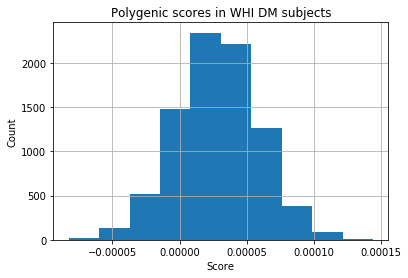

In [15]:
regscores_dm_df.SCORE.hist()
plt.title("Polygenic scores in WHI DM subjects")
plt.xlabel("Score")
plt.ylabel("Count")

In [16]:
(smf.ols("ldl ~ sfa + pufa + SCORE:sfa + age", data=regscores_dm_df)
 .fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,132.8533,5.733,23.174,0.000,121.615,144.092
sfa,-33.7202,194.268,-0.174,0.862,-414.563,347.122
pufa,-624.6699,221.712,-2.817,0.005,-1059.314,-190.026
SCORE:sfa,4.269e+06,1.17e+06,3.644,0.000,1.97e+06,6.57e+06
age,0.2925,0.072,4.056,0.000,0.151,0.434


/cluster/kappa/90-days-archive/rt/software/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,u'Slope of SFA -> LDL relationship')

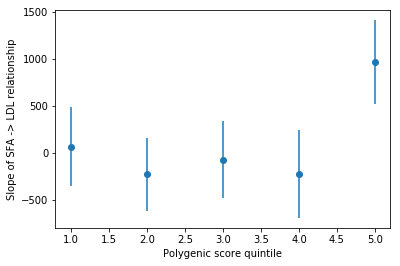

In [17]:
n_quantiles = 5

regscores_dm_df['quant'] = pd.qcut(regscores_dm_df.SCORE, n_quantiles)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ sfa + pufa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa)

param_estimates = [find_slope(regscores_dm_df[regscores_dm_df.quant == q]) 
                   for q in regscores_dm_df.quant.cat.categories]

slopes, ses = zip(*param_estimates)

plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")

In [18]:
regscores_dm_intervention_df['SCORE'] = regscores_dm_intervention_df.index.get_level_values('SCORE')
regscores_dm_intervention_df['race'] = regscores_dm_intervention_df.index.get_level_values('race')
regscores_dm_intervention_df['age'] = regscores_dm_intervention_df.index.get_level_values('age')

regscores_dm_control_df['SCORE'] = regscores_dm_control_df.index.get_level_values('SCORE')
regscores_dm_control_df['race'] = regscores_dm_control_df.index.get_level_values('race')
regscores_dm_control_df['age'] = regscores_dm_control_df.index.get_level_values('age')

(smf.ols("ldl ~ SCORE", data=regscores_dm_intervention_df)
 .fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.5737,1.996,-3.293,0.001,-10.499,-2.649
SCORE,-1.742e+05,5.04e+04,-3.455,0.001,-2.73e+05,-7.51e+04


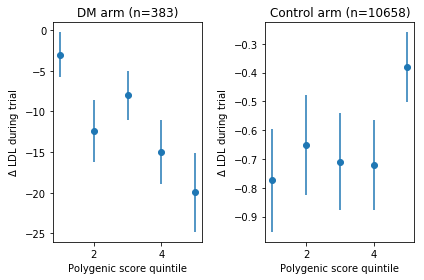

In [19]:
n_quantiles = 5

regscores_dm_intervention_df['quant'] = pd.qcut(regscores_dm_intervention_df.SCORE, n_quantiles)
regscores_dm_control_df['quant'] = pd.qcut(regscores_dm_control_df.SCORE, n_quantiles)

def find_ldl_change(sub_df):
    return (sub_df.ldl.mean(), sub_df.ldl.std()/np.sqrt(sub_df.ldl.count()))

change_estimates_intervention = [find_ldl_change(
    regscores_dm_intervention_df[regscores_dm_intervention_df.quant == q]) 
                    for q in regscores_dm_intervention_df.quant.cat.categories]
change_estimates_control = [find_ldl_change(
    regscores_dm_control_df[regscores_dm_control_df.quant == q]) 
                    for q in regscores_dm_control_df.quant.cat.categories]

deltas, ses = zip(*change_estimates_intervention)
plt.subplot(1, 2, 1)
plt.errorbar(x=range(1,n_quantiles+1), y=deltas, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("$\Delta$ LDL during trial")
plt.title("DM arm (n={})".format(regscores_dm_intervention_df.ldl.count()))
plt.tight_layout()
deltas, ses = zip(*change_estimates_control)
plt.subplot(1, 2, 2)
plt.errorbar(x=range(1,n_quantiles+1), y=deltas, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("$\Delta$ LDL during trial")
plt.title("Control arm (n={})".format(regscores_dm_control_df.ldl.count()))
plt.tight_layout()

Does BPRHS replicate any better using this regression-based score?

In [20]:
bprhs_regscores = (pd.read_csv("bprhs_lasso_scores.sscore", delim_whitespace=True)
                .loc[:, ['IID', 'SCORE1_AVG']])
bprhs_regscores.columns = ['nelid_b', 'SCORE']
bprhs_regscores['nelid_b'] = bprhs_scores['nelid_b'].astype(str)

regscores_df_bprhs = (pd.merge(meta_bprhs, bprhs_id_link, on='studyid')
                   .merge(bprhs_regscores, on='nelid_b'))

In [21]:
smf.ols('ldl ~ pufa + sfa + sfa:SCORE', data=regscores_df_bprhs).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,113.5376,6.324,17.954,0.000,101.125,125.950
pufa,-445.1607,484.086,-0.920,0.358,-1395.327,505.005
sfa,248.2668,540.894,0.459,0.646,-813.402,1309.936
sfa:SCORE,1.714e+06,4.87e+06,0.352,0.725,-7.85e+06,1.13e+07


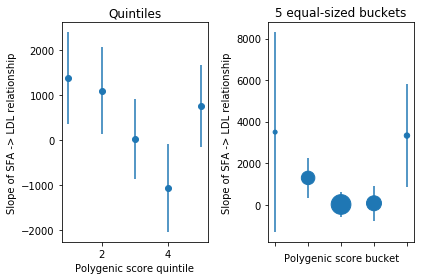

In [22]:
n_quantiles = 5
n_buckets = 5

regscores_df_bprhs['quant'] = pd.qcut(regscores_df_bprhs.SCORE, n_quantiles)
regscores_df_bprhs['bucket'] = pd.cut(regscores_df_bprhs.SCORE, n_buckets)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ pufa + sfa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa, reg_fit.nobs)

param_estimates = [find_slope(regscores_df_bprhs[regscores_df_bprhs.quant == q]) 
                   for q in regscores_df_bprhs.quant.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 1)
plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("Quintiles")
plt.tight_layout()

param_estimates = [find_slope(regscores_df_bprhs[regscores_df_bprhs.bucket == q]) 
                   for q in regscores_df_bprhs.bucket.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 2)
plt.scatter(x=range(1, n_quantiles + 1), y=slopes, s=N)
plt.errorbar(x=range(1, n_quantiles + 1), y=slopes, yerr=ses, fmt="none")
plt.xlabel("Polygenic score bucket")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("5 equal-sized buckets")
plt.xticks(range(1, 6), [])
plt.tight_layout()

## Score overlap among cohorts and ethnicities

How much might ethnicity be causing the observed results here?
(Note: each BPRHS value is repeated 5x in the below plot so its distribution is more visible in comparison to the WHI sample sizes.)

Text(0,0.5,u'Count')

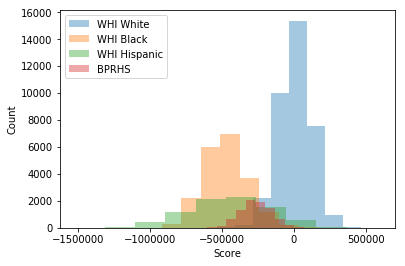

In [23]:
race_dfs = {'WHI White': scores_df.query('race == "white"'),
            'WHI Black': scores_df.query('race == "black"'),
            'WHI Hispanic': scores_df.query('race == "hispanic"'),
            'BPRHS': scores_df_bprhs}

race_scores = {k: v.SCORE * 1e4 for (k, v) in race_dfs.items()}
race_scores['BPRHS'] = pd.concat([race_scores['BPRHS']] * 10)

for (race, scores) in race_scores.items():
    plt.hist(scores, alpha=0.4, label=race)
plt.legend()
plt.xlabel("Score")
plt.ylabel("Count")

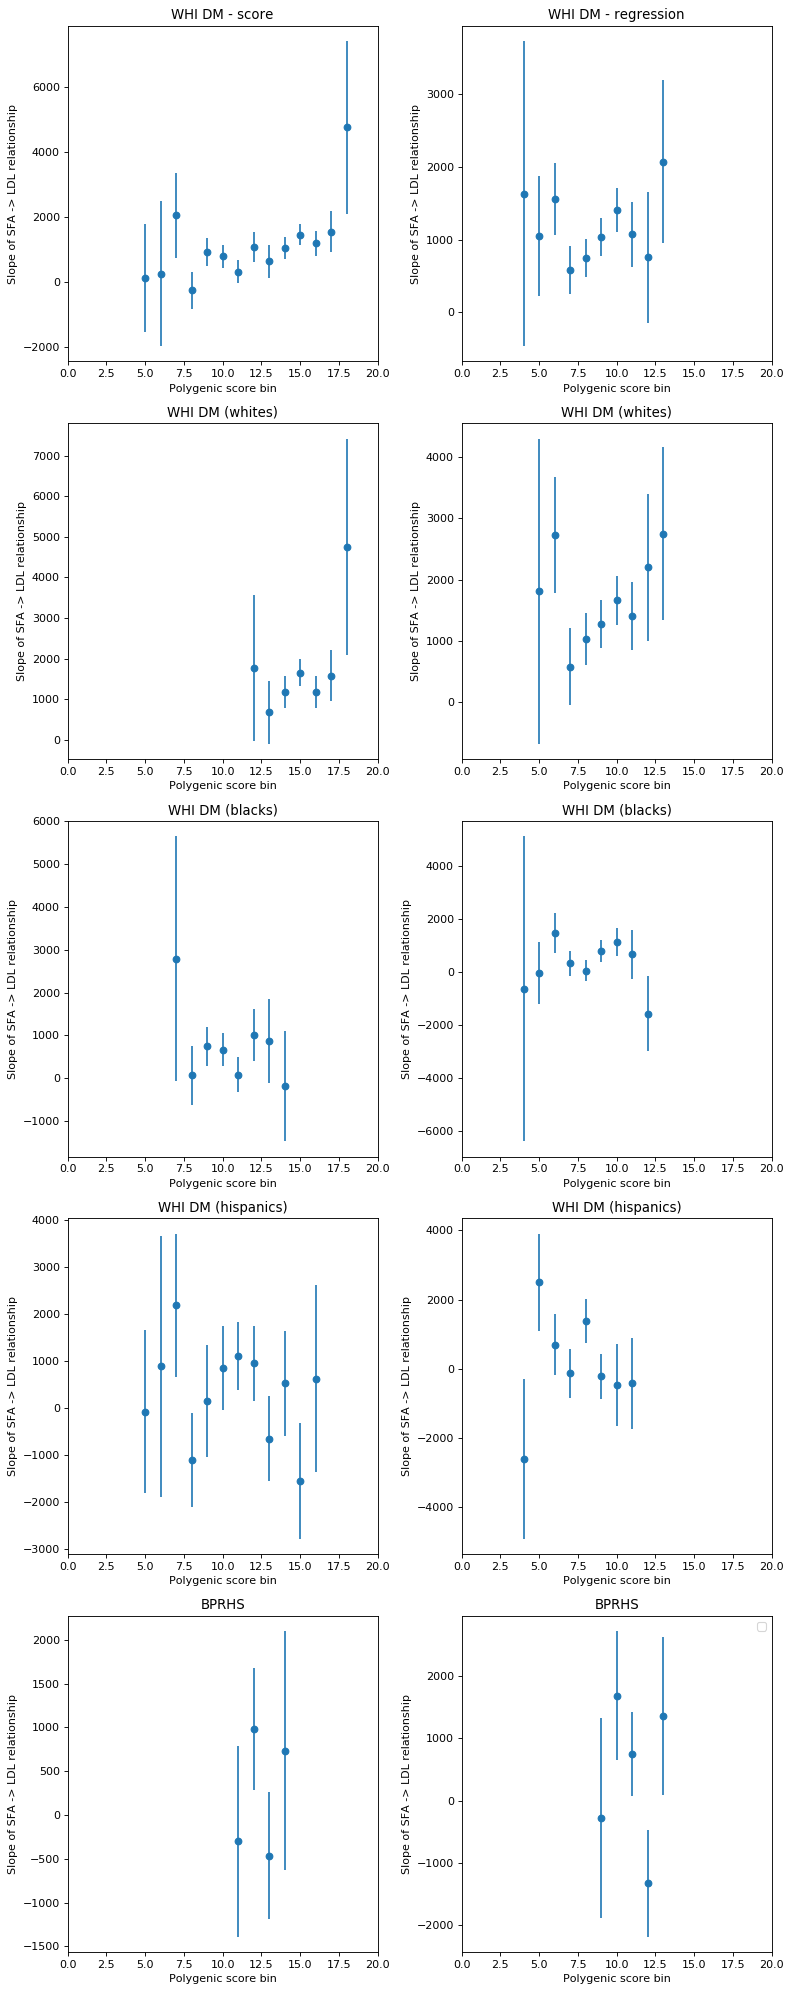

In [29]:
score_bins = pd.cut(pd.concat([scores_df.SCORE, scores_df_bprhs.SCORE]), 20).cat.categories  # IntervalIndex dtype
regscore_bins = pd.cut(pd.concat([regscores_df.SCORE, regscores_df_bprhs.SCORE]), 20).cat.categories  # IntervalIndex dtype

def find_slope(df):
    if df.shape[0] < 50:
        return (np.inf, np.inf, np.inf)
    else:
        reg_fit = smf.ols("ldl ~ sfa + pufa + age", data=df).fit()
        return (reg_fit.params.sfa, reg_fit.bse.sfa, reg_fit.nobs)

def generate_slope_plot(df, intervals, title):
    bins = pd.cut(df.SCORE, intervals)
    param_estimates = [find_slope(df[bins == i]) for i in intervals]
    param_estimates = [p if p[2] > 5 else (0, 0, 0) for p in param_estimates]
    betas, ses, N = zip(*param_estimates)
       
    plt.errorbar(x=range(1, len(intervals) + 1), y=betas, yerr=ses, 
                 fmt="o")
    plt.xlim(0, len(score_bins))
    plt.xlabel("Polygenic score bin")
    plt.ylabel("Slope of SFA -> LDL relationship")
    plt.title(title)
    plt.tight_layout()

    return N

test_df = scores_df.query('dm_trial == True')
regtest_df = regscores_df.query('dm_trial == True')
fig=plt.figure(figsize=(10, 25), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(5, 2, 1)
generate_slope_plot(test_df, score_bins, "WHI DM - score")
plt.subplot(5, 2, 2)
generate_slope_plot(regtest_df, regscore_bins, "WHI DM - regression")
plt.subplot(5, 2, 3)
generate_slope_plot(test_df.query('race == "white"'), score_bins, "WHI DM (whites)")
plt.subplot(5, 2, 4)
generate_slope_plot(regtest_df.query('race == "white"'), regscore_bins, "WHI DM (whites)")
plt.subplot(5, 2, 5)
generate_slope_plot(test_df.query('race == "black"'), score_bins, "WHI DM (blacks)")
plt.subplot(5, 2, 6)
generate_slope_plot(regtest_df.query('race == "black"'), regscore_bins, "WHI DM (blacks)")
plt.subplot(5, 2, 7)
generate_slope_plot(test_df.query('race == "hispanic"'), score_bins, "WHI DM (hispanics)")
plt.subplot(5, 2, 8)
generate_slope_plot(regtest_df.query('race == "hispanic"'), regscore_bins, "WHI DM (hispanics)")
plt.subplot(5, 2, 9)
generate_slope_plot(scores_df_bprhs, score_bins, "BPRHS")
plt.subplot(5, 2, 10)
generate_slope_plot(regscores_df_bprhs, regscore_bins, "BPRHS")
plt.legend()

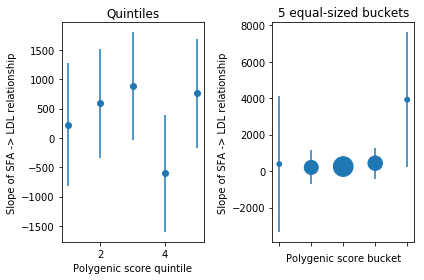

In [25]:
scores_df_bprhs['quant'] = pd.qcut(scores_df_bprhs.SCORE, n_quantiles)
scores_df_bprhs['bucket'] = pd.cut(scores_df_bprhs.SCORE, n_buckets)

def find_slope(sub_df):
    reg_fit = smf.ols("ldl ~ pufa + sfa + age", data=sub_df).fit()
    return (reg_fit.params.sfa, reg_fit.bse.sfa, reg_fit.nobs)

param_estimates = [find_slope(scores_df_bprhs[scores_df_bprhs.quant == q]) 
                   for q in scores_df_bprhs.quant.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 1)
plt.errorbar(x=range(1,n_quantiles+1), y=slopes, yerr=ses, fmt="o")
plt.xlabel("Polygenic score quintile")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("Quintiles")
plt.tight_layout()

param_estimates = [find_slope(scores_df_bprhs[scores_df_bprhs.bucket == q]) 
                   for q in scores_df_bprhs.bucket.cat.categories]
slopes, ses, N = zip(*param_estimates)

plt.subplot(1, 2, 2)
plt.scatter(x=range(1, n_quantiles + 1), y=slopes, s=N)
plt.errorbar(x=range(1, n_quantiles + 1), y=slopes, yerr=ses, fmt="none")
plt.xlabel("Polygenic score bucket")
plt.ylabel("Slope of SFA -> LDL relationship")
plt.title("5 equal-sized buckets")
plt.xticks(range(1, 6), [])
plt.tight_layout()